In [1]:
cd ~/Desktop/workbench/cs330-final

/Users/gautam/Desktop/workbench/cs330-final


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import itertools

import matplotlib.pyplot as plt

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from tqdm import tqdm

import datasets
import model
import utils
import train

/Users/gautam/miniconda3/envs/cs330/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Task Setup
Setup datasets, loss functions, etc.

In [4]:
bs = 128

mnist_train = datasets.MNIST(train=True)
fmnist_train = datasets.FashionMNIST(train=True)

mnist_val = datasets.MNIST(train=False)
fmnist_val = datasets.FashionMNIST(train=False)

mnist_train_loader = DataLoader(mnist_train, batch_size=bs, shuffle=True, drop_last=True)
fmnist_train_loader = DataLoader(fmnist_train, batch_size=bs, shuffle=True, drop_last=True)

mnist_iter = itertools.cycle(mnist_train_loader)
fmnist_iter = itertools.cycle(fmnist_train_loader)

In [16]:
import torchvision
z = 

In [18]:
tasks = {
    'mnist': {
        'train_iter': mnist_iter,
        'eval_ds': mnist_val,
        'loss': lambda logits, labels: F.cross_entropy(logits, labels),
        'predict': lambda logits: torch.argmax(logits, dim=-1),
        'metric': lambda yh, y: utils.accuracy(yh, y.long()),
    },
    'fashion_mnist': {
        'train_iter': fmnist_iter,
        'eval_ds': fmnist_val,
        'loss': lambda logits, labels: F.cross_entropy(logits, labels),
        'predict': lambda logits: torch.argmax(logits, dim=-1),
        'metric': lambda yh, y: utils.accuracy(yh, y.long()),
    },
}

## Compute gradient alignments

In [31]:
class SharedMTL(nn.Module):
    def __init__(self, task_keys):
        super().__init__()
        self.proj = nn.Conv2d(1, 3, 1)
        self.backbone = torchvision.models.resnet18(pretrained=True)
        self.heads = nn.ModuleDict({
            task: nn.Linear(1000, 10)
            for task in task_keys
        })
    
    def forward(self, x, task):
        x = self.proj(x[:, None, ...])
        return self.heads[task](self.backbone(x)) 


shared_mtl = SharedMTL(tasks.keys())
grads = train.get_gradients(
    model=shared_mtl,
    tasks=tasks, 
    steps=10, 
    lr=3e-4,
)






  0%|                                                                             | 0/10 [00:00<?, ?it/s]




 10%|██████▉                                                              | 1/10 [00:02<00:20,  2.24s/it]




 20%|█████████████▊                                                       | 2/10 [00:04<00:17,  2.23s/it]




 30%|████████████████████▋                                                | 3/10 [00:06<00:16,  2.36s/it]




 40%|███████████████████████████▌                                         | 4/10 [00:09<00:13,  2.31s/it]




 50%|██████████████████████████████████▌                                  | 5/10 [00:11<00:11,  2.27s/it]




 60%|█████████████████████████████████████████▍                           | 6/10 [00:13<00:09,  2.31s/it]




 70%|████████████████████████████████████████████████▎                    | 7/10 [00:16<00:07,  2.47s/it]




 80%|███████████████████████████████████████████████████████▏             | 8/10 [00:18<00:04,  2.40s/it]




 90%|

['backbone.conv1.weight', 'backbone.bn1.weight', 'backbone.bn1.bias', 'backbone.bn1.running_mean', 'backbone.bn1.running_var', 'backbone.bn1.num_batches_tracked', 'backbone.layer1.0.conv1.weight', 'backbone.layer1.0.bn1.weight', 'backbone.layer1.0.bn1.bias', 'backbone.layer1.0.bn1.running_mean', 'backbone.layer1.0.bn1.running_var', 'backbone.layer1.0.bn1.num_batches_tracked', 'backbone.layer1.0.conv2.weight', 'backbone.layer1.0.bn2.weight', 'backbone.layer1.0.bn2.bias', 'backbone.layer1.0.bn2.running_mean', 'backbone.layer1.0.bn2.running_var', 'backbone.layer1.0.bn2.num_batches_tracked', 'backbone.layer1.1.conv1.weight', 'backbone.layer1.1.bn1.weight', 'backbone.layer1.1.bn1.bias', 'backbone.layer1.1.bn1.running_mean', 'backbone.layer1.1.bn1.running_var', 'backbone.layer1.1.bn1.num_batches_tracked', 'backbone.layer1.1.conv2.weight', 'backbone.layer1.1.bn2.weight', 'backbone.layer1.1.bn2.bias', 'backbone.layer1.1.bn2.running_mean', 'backbone.layer1.1.bn2.running_var', 'backbone.layer1.1

IndexError: index 30 is out of bounds for axis 0 with size 30

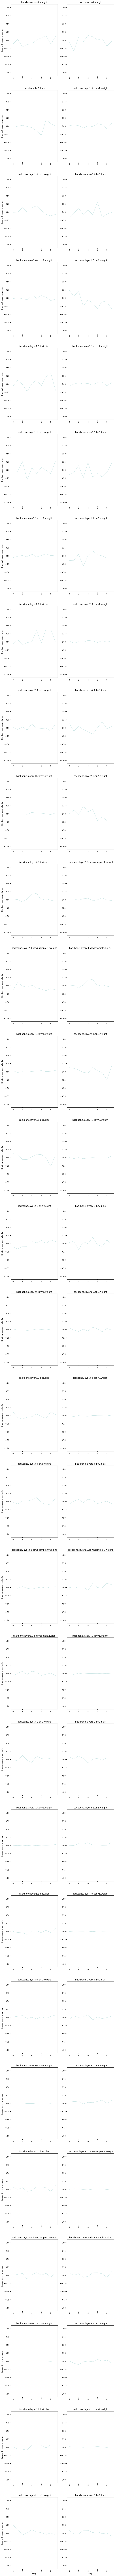

In [61]:
param_keys = ['backbone.' + k for k in list(shared_mtl.backbone.state_dict().keys())]
print(param_keys)

heuristic_results = {}

# plots
n_rows = 30
n_cols = 2
fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 250))

c = 0
for i, key in enumerate(param_keys):
    if 'running_mean' in key or 'running_var' in key or 'batches_tracked' in key:
        continue

    # get gradients
    g0 = utils.stack_grad(grads, 'mnist', key)
    g1 = utils.stack_grad(grads, 'fashion_mnist', key)
    
    # heuristics computations
    cosine = torch.sum(F.normalize(g0, dim=-1) * F.normalize(g1, dim=-1), dim=-1)
    smooth_cos = utils.low_pass_filter(cosine[None], filter_size=10)[0][0]
    
    avg_smoothed_cos = smooth_cos.mean()
    std_cos = cosine.std()
    
    heuristic_results[key] = {'avg_cos': avg_smoothed_cos, 'std_cos': std_cos}
      
    # plot
    row, col = c // n_cols, c % n_cols
    c += 1
    ax = axes[row][col]    
    ax.set_title(key)
    if col == 0:
        ax.set_ylabel('Gradient cosine similarity')
    if row == n_rows - 1:
        ax.set_xlabel('Step')
    ax.set_ylim([-1.1, 1.1])
    ax.plot(cosine, color='teal', alpha=0.2)
    ax.plot(smooth_cos, color='teal')

KeyError: 'backbone.bn1.running_mean'

In [59]:
heuristic_results
print('param\t\t\t\t\tavg_cos\tstd_cos')
for k, v in heuristic_results.items():
    print(f'{k}\t\t\t\t\t{v["avg_cos"]:.4f}\t{v["std_cos"]:.4f}')

param					avg_cos	std_cos
backbone.conv1.weight					-0.0372	0.1196
backbone.bn1.weight					-0.0274	0.1440
backbone.bn1.bias					-0.0253	0.1272
backbone.layer1.0.conv1.weight					0.0068	0.0528
backbone.layer1.0.bn1.weight					0.0211	0.1020
backbone.layer1.0.bn1.bias					-0.0149	0.1467
backbone.layer1.0.conv2.weight					-0.0025	0.0562
backbone.layer1.0.bn2.weight					-0.0852	0.2041
backbone.layer1.0.bn2.bias					0.0227	0.1762
backbone.layer1.1.conv1.weight					0.0012	0.0457
backbone.layer1.1.bn1.weight					0.0049	0.1718
backbone.layer1.1.bn1.bias					-0.0551	0.1775
backbone.layer1.1.conv2.weight					0.0029	0.0382
backbone.layer1.1.bn2.weight					-0.0486	0.1288
backbone.layer1.1.bn2.bias					0.0962	0.1964
backbone.layer2.0.conv1.weight					0.0088	0.0307
backbone.layer2.0.bn1.weight					0.0007	0.0767
backbone.layer2.0.bn1.bias					-0.0094	0.1164
backbone.layer2.0.conv2.weight					0.0038	0.0211
backbone.layer2.0.bn2.weight					-0.0068	0.1482
backbone.layer2.0.bn2.bias					0.0275	0.0862
back

## Experiments

In [15]:
mtl = SharedMTL(tasks.keys())
fully_shared_exp = train.train_and_evaluate(
    model=mtl,
    tasks=tasks,
    steps=1000,
    lr=1e-4,
    eval_every=50,
)

100%|███████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 100.00it/s]


In [16]:
class SeparateMTL(nn.Module):
    def __init__(self, task_keys):
        super().__init__()
        self.backbones = nn.ModuleDict({
            task: model.LinearBackbone()
            for task in task_keys
        })
        self.heads = nn.ModuleDict({
            task: nn.Linear(256, 10)
            for task in task_keys
        })
    
    def forward(self, x, task):
        return self.heads[task](self.backbones[task](x)) 

mtl = SeparateMTL(tasks.keys())
separate_exp = train.train_and_evaluate(
    model=mtl,
    tasks=tasks,
    steps=1000,
    lr=1e-4,
    eval_every=50,
)

100%|████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 89.46it/s]


In [17]:
class SurgicalMTL(nn.Module):
    def __init__(self, task_keys):
        super().__init__()
        self.backbone = model.Shareable(
            mdl=model.LinearBackbone(),
            task_keys=list(task_keys),
            shared_params=['net.0.bias', 'net.2.bias']
        )
        self.heads = nn.ModuleDict({
            task: nn.Linear(256, 10)
            for task in task_keys
        })
    
    def forward(self, x, task):
        return self.heads[task](self.backbone(x, task))

mtl = SurgicalMTL(tasks.keys())
surgical_exp = train.train_and_evaluate(
    model=mtl,
    tasks=tasks,
    steps=1000,
    lr=1e-4,
    eval_every=50,
)

100%|████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 90.65it/s]


In [29]:
m = z.state_dict()
m['net.0.weight'].device

device(type='cpu')

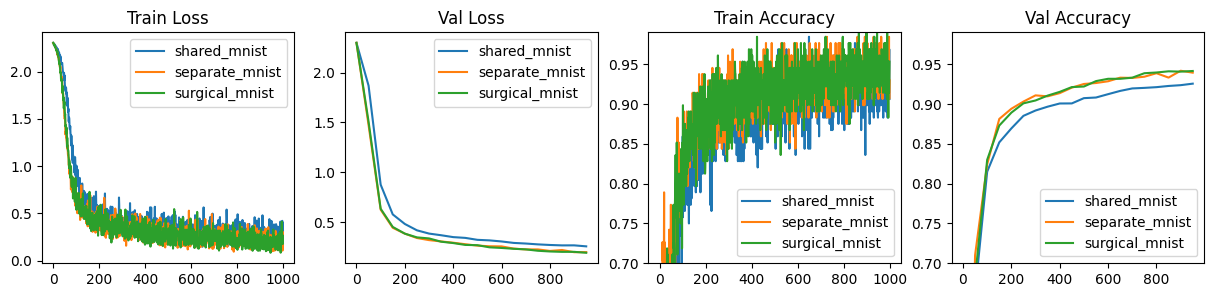

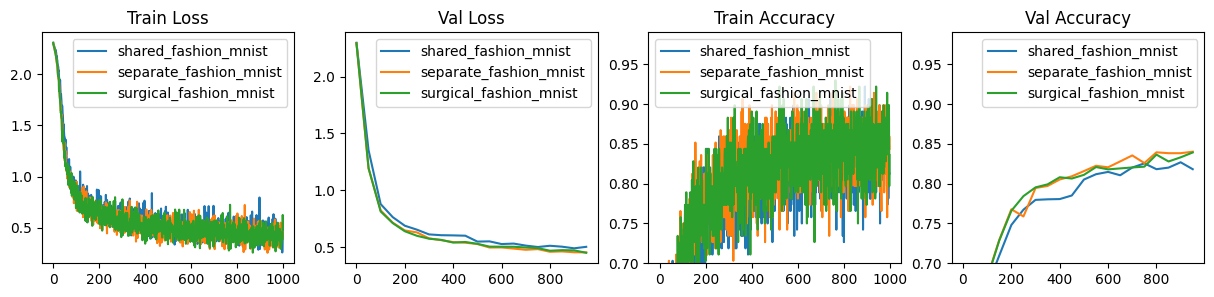

In [19]:
for task_name in tasks:
    fig, axes = plt.subplots(1, 4, figsize=(15, 3))

    for exp_name, exp in [
        ('shared', fully_shared_exp),
        ('separate', separate_exp),
        ('surgical', surgical_exp),
    ]:
        losses, metrics, eval_losses, eval_metrics = exp
        
        tl = [(s, l[task_name]) for s, l in losses]
        el = [(s, l[task_name]) for s, l in eval_losses]
        tm = [(s, m[task_name]) for s, m in metrics]
        em = [(s, m[task_name]) for s, m in eval_metrics]
    
        # plot
        ax = axes[0]
        tl_x, tl_y = zip(*tl)
        ax.plot(tl_x, tl_y, label=f'{exp_name}_{task_name}')
        ax.set_title('Train Loss')
        # ax.set_yscale('log')
        ax.legend()

        ax = axes[1]
        el_x, el_y = zip(*el)
        ax.plot(el_x, el_y, label=f'{exp_name}_{task_name}')
        ax.set_title('Val Loss')
        # ax.set_yscale('log')
        ax.legend()

        ax = axes[2]
        tm_x, tm_y = zip(*tm)
        ax.plot(tm_x, tm_y, label=f'{exp_name}_{task_name}')
        ax.set_title('Train Accuracy')
        ax.set_ylim([0.7, 0.99])
        ax.legend()

        ax = axes[3]
        em_x, em_y = zip(*em)
        ax.plot(em_x, em_y, label=f'{exp_name}_{task_name}')
        ax.set_title('Val Accuracy')
        ax.set_ylim([0.7, 0.99])
        ax.legend()